<a href="https://colab.research.google.com/github/ahshawaf/AML/blob/master/Project5_Team1_Ahmad_SeanV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://images.everydayhealth.com/images/diabetes/type-1-diabetes/common-virus-may-have-ties-to-type-1-diabetes-1440x810.jpg?w=1110)

#Diabetes Patients Classification Learning

Management of hyperglycemia in hospitalized patients has a significant bearing on outcome, in terms of both morbidity and
mortality. However, there are few national assessments of diabetes care during hospitalization which could serve as a baseline for
change.This analysis of a large clinical database (74 million unique encounters corresponding to 17 million unique patients) was
undertaken to provide such an assessment and to find future directions which might lead to improvements in patient safety. Almost
70,000 inpatient diabetes encounters were identified with sufficient detail for analysis.Multivariable logistic regression was used to
fit the relationship between themeasurement of HbA1c and early readmissionwhile controlling for covariates such as demographics,
severity and type of the disease, and type of admission. Results show that the measurement of HbA1c was performed infrequently
(18.4%) in the inpatient setting. The statistical model suggests that the relationship between the probability of readmission and the
HbA1c measurement depends on the primary diagnosis.The data suggest further that the greater attention to diabetes reflected in
HbA1c determination may improve patient outcomes and lower cost of inpatient care.

#Setup

In [0]:
# Common Import
import sklearn
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
import time
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, mean_squared_error
from math import sqrt

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# sklearn version > 0.20 is required 
sklearn.__version__
# Update sklearn -> !pip install -U scikit-learn

'0.22.2.post1'

#Data Scrubbing

##Loading Data

In this section, loading and viewing data are shown.

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/seansothey/CSC685/master/diabetic_data.csv')
df.head(10)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,31,6,16,0,0,0,414,411,250,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30
6,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,70,1,21,0,0,0,414,411,V45,7,None,None,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
7,63768,114882984,Caucasian,Male,[70-80),?,1,1,7,5,?,?,73,0,12,0,0,0,428,492,250,8,None,None,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,>30
8,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,68,2,28,0,0,0,398,427,38,8,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
9,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,33,3,18,0,0,0,434,198,486,8,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


##Exploring Data

here, the data will be investigated to see if there is missing data and also to figure out any other issue in the data.


See the data information

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

Here is more information about data.

In [0]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


Next, check the number of object types.

In [0]:
df.dtypes.value_counts()

object    37
int64     13
dtype: int64

It is concluded that there are total 50 columns/features. The breakdown is as follows:
- 2 columns are target variable/labels ('diabetesMed and 'readmitted'), both has nominal value.
- 48 columns are features, and 35 columns has nominal value and 13 columns has numeric value.

Check if there is 'NaN' value in the data

In [0]:
df.isna().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazo

From the above, there is no 'NaN' value in dataframe.

From the sample data above, the missing data were marked as '?'. Let see in the dataframe and count them.

In [0]:
missing_data=df.isin(['?']).sum()
missing_data

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

Calculate the percentage of the missing for the column that has that.

In [0]:
#Custom function to calculate the precentage of an attribute
def cal_Percentage(attributeName,missing_data=missing_data,dataFrame=df):
    print('{0}: {1:.2f} % missing data'.format(attributeName,missing_data[attributeName]/len(df)*100))

In [0]:
for att in missing_data.keys():
  if missing_data[att] > 0:
    cal_Percentage(att)

race: 2.23 % missing data
weight: 96.86 % missing data
payer_code: 39.56 % missing data
medical_specialty: 49.08 % missing data
diag_1: 0.02 % missing data
diag_2: 0.35 % missing data
diag_3: 1.40 % missing data


From the above, it shows that the follwing attributes has missing data:
1.   race 2%
2.   weight 97%
3.   payer_code 40% 
4.   medical_specialty 49%
5.   diag_1 0.02%
6.   diag_2 0.35%
7.   diag_3 1.40%

##Features Engineering


Let's see the correlation of each feature using heatmap.

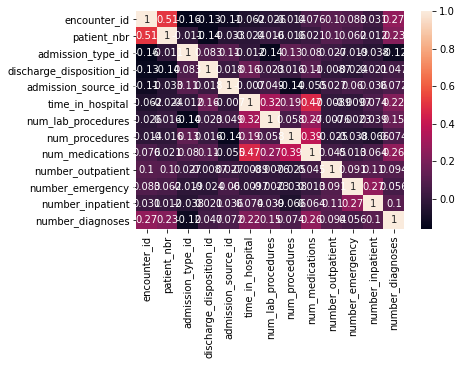

In [0]:
corr = df.corr()
sns.heatmap(corr, annot = True)

This can be seen that there aren't any high correlation (value >0.8) between each feature. However, this doesn't mean that all features are needed to be used to fit the learning model, such as patient_id, physician_id, payer_id, etc. The data value of these types are meaningless for aggregation, like mean, total, min and max, etc. Therefore, as a data scientist, this should be able to defined before conducting feature engineering

Now, let's drop some columnus that has value as id and missing value greater than 70%

In [0]:
data = df.drop(['encounter_id','patient_nbr','weight','admission_type_id','discharge_disposition_id',
                  'admission_source_id','payer_code','medical_specialty','diag_1','diag_2','diag_3'], axis=1)

data.shape

(101766, 39)

##Data Visualization

Display data in histgram charts to see how is the data distributed.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9026aeeb38>,
      dtype=object)

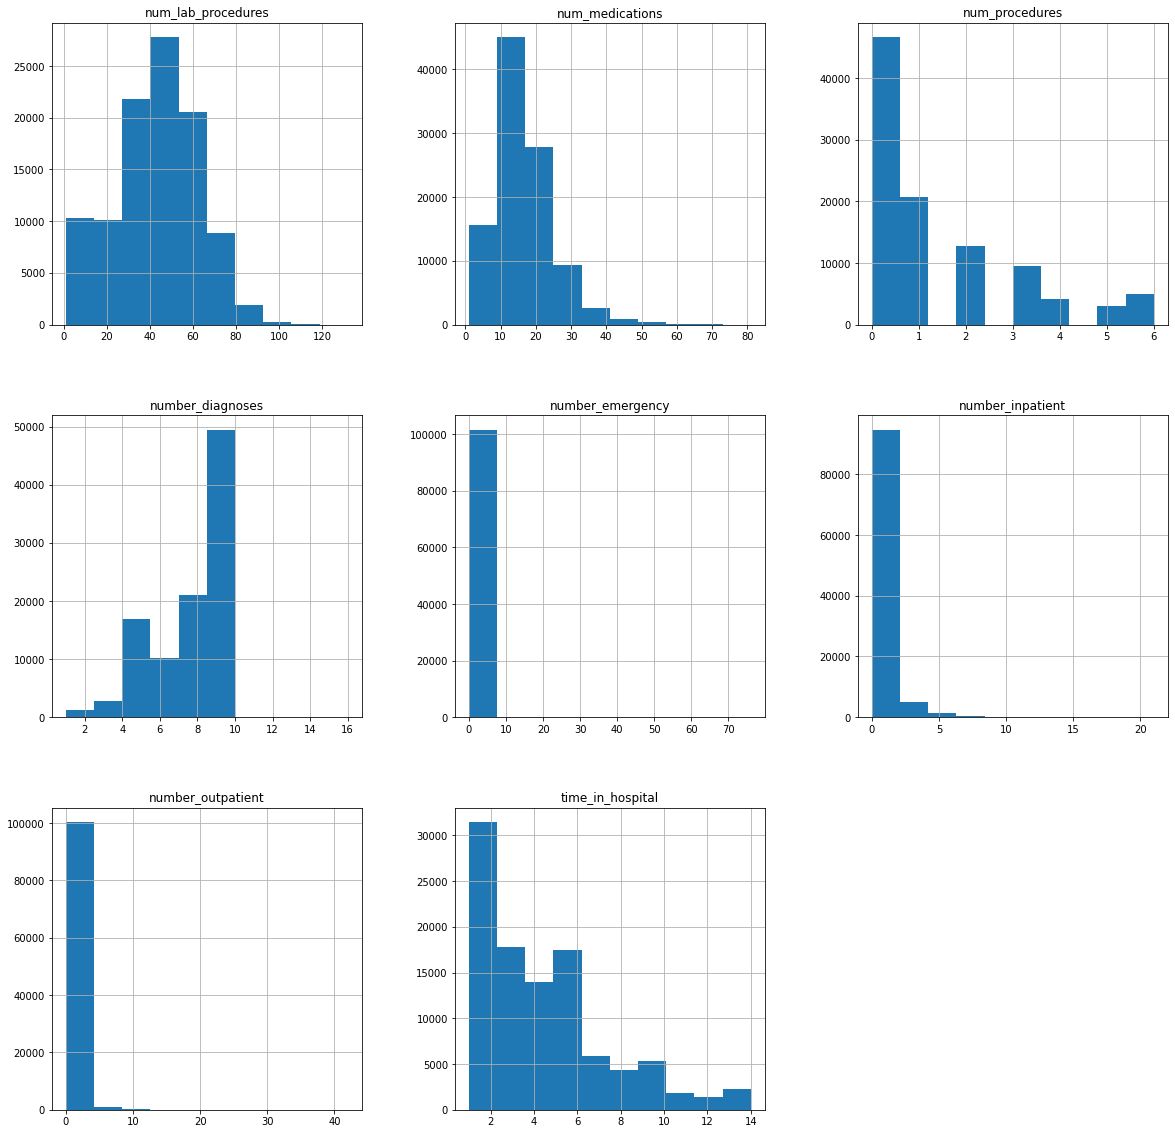

In [0]:
data.hist(figsize=(20,20))

In [0]:
def getRandomColor():
    r = random.randint(0,255)/255
    g = random.randint(0,255)/255
    b = random.randint(0,255)/255
    rgb=[r,g,b]
    return rgb
def groupByChart(attr,title):

  count_y_genered=data.groupby(attr).count()
  plt.figure(figsize=(20,10))
  count = 0;

  attr=count_y_genered.keys()
  cats=count_y_genered[attr[0]].keys()
  #To assign a color for each catagory
  colors = dict()

  for cat in cats:
    colors[cat]=getRandomColor()
  #To assign a position for each catogory
  positions = dict()
  for key in attr:
    for cat in cats:
      positions[cat]=count_y_genered[key][cat]

  barWidth = 0.9
  for key in attr:
    for cat in cats:
      plt.bar(-0.20+count,count_y_genered[key][cat],color=colors[cat],width=barWidth)
      count +=1

  plt.legend(cats)
  plt.xticks([(barWidth+r-0.85)*len(cats) for r in range(len(attr))],attr,rotation=90)
  plt.title(title)
  plt.show()

##Group By Gender


In [0]:
data.groupby('gender').count()

,race,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
gender,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Female,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708
Male,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055
Unknown/Invalid,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3


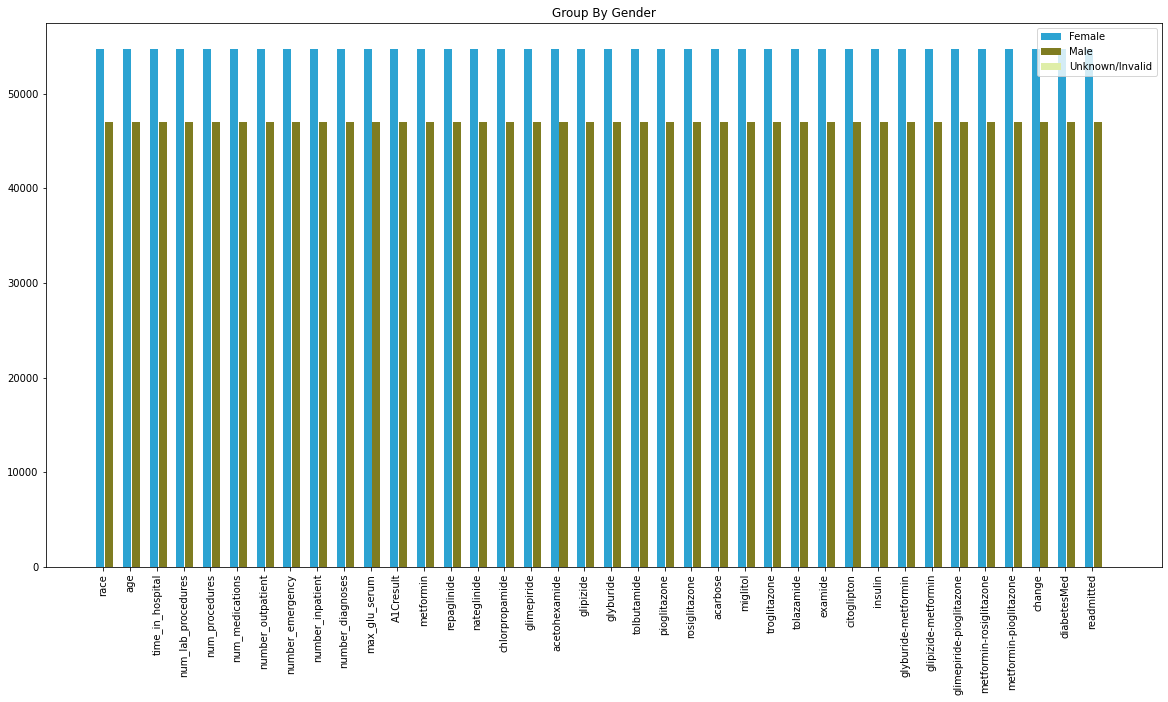

In [0]:
groupByChart('gender','Group By Gender')

##Group By Age

In [0]:
data.groupby('age').count()

,race,gender,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
age,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
[0-10),161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161
[10-20),691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691
[20-30),1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657
[30-40),3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775
[40-50),9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685
[50-60),17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256
[60-70),22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483
[70-80),26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068
[80-90),17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197


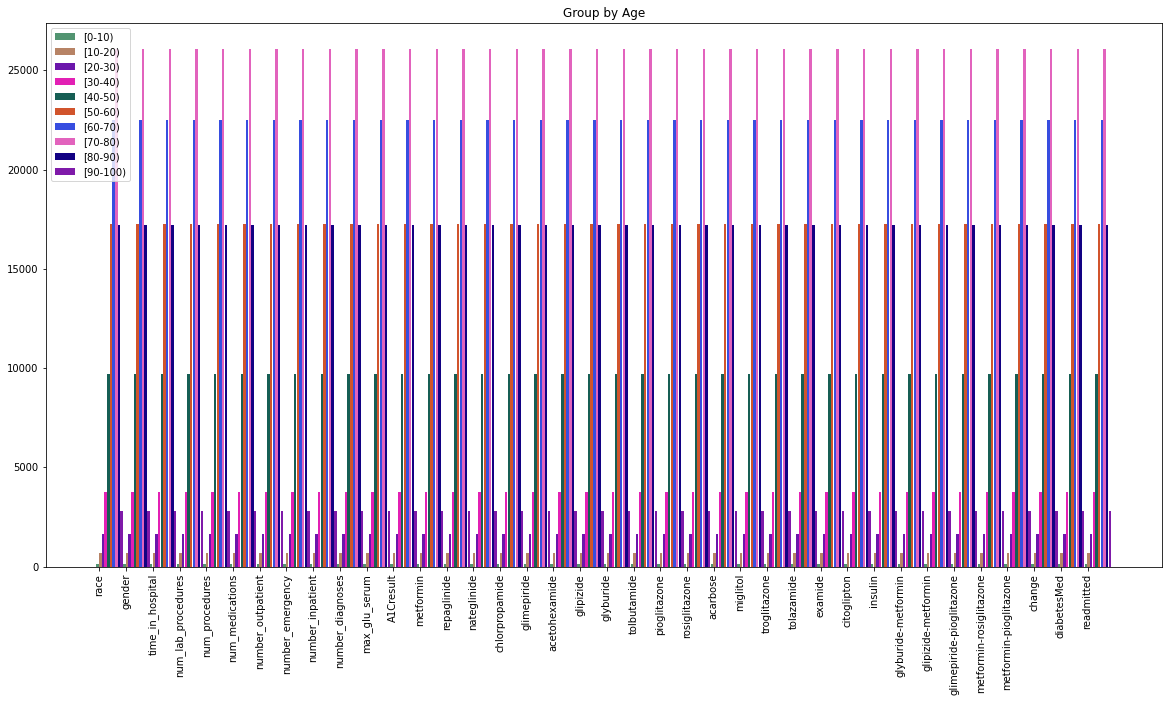

In [0]:
groupByChart('age','Group by Age')

##Group By Race


In [0]:
data.groupby('race').count()

,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
race,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
?,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273
AfricanAmerican,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210
Asian,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641
Caucasian,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099
Hispanic,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037
Other,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506


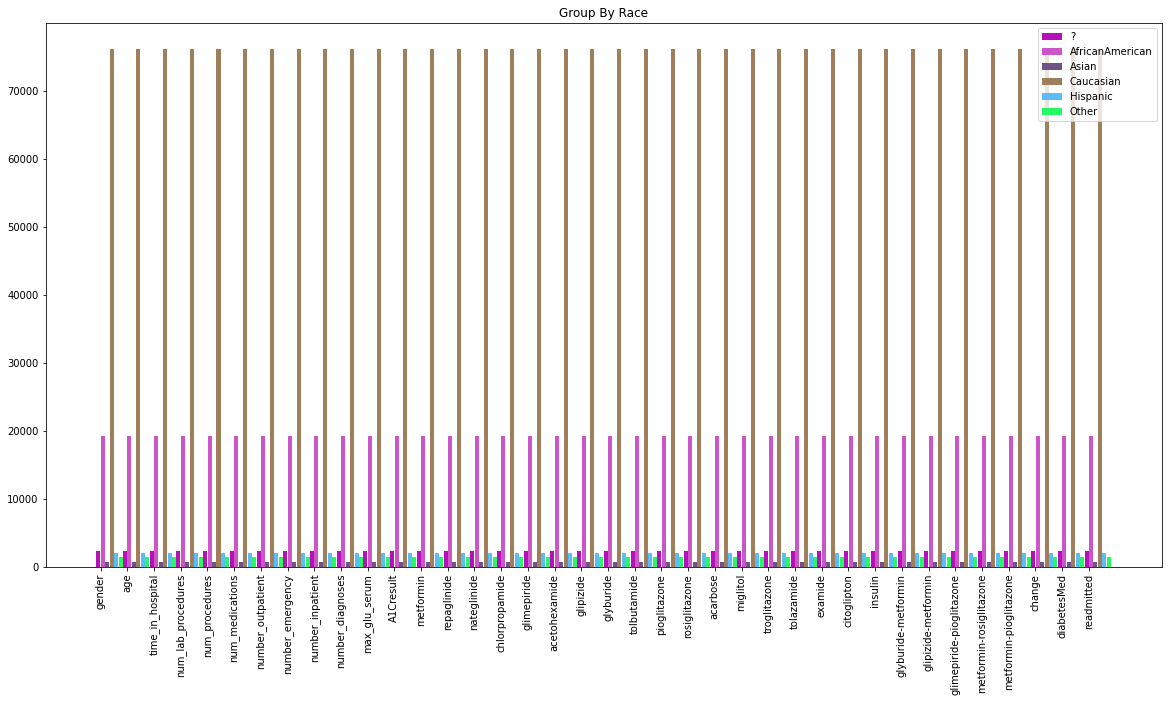

In [0]:
groupByChart('race','Group By Race')

##Group By Diabetes Medication Prescribed

In [0]:
data.groupby('diabetesMed').count()

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,readmitted
diabetesMed,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
No,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403
Yes,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363


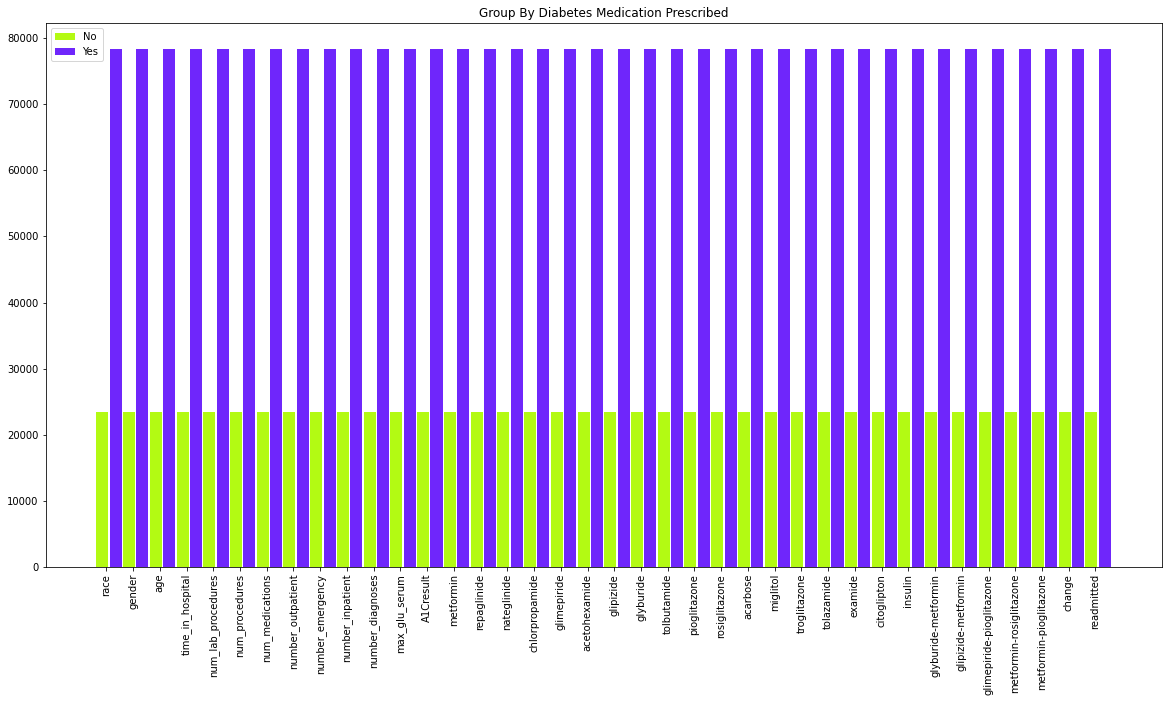

In [0]:
groupByChart('diabetesMed','Group By Diabetes Medication Prescribed')

## Group by Readmitted

In [0]:
data.groupby('readmitted').count()

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
readmitted,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
<30,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357
>30,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545
NO,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864


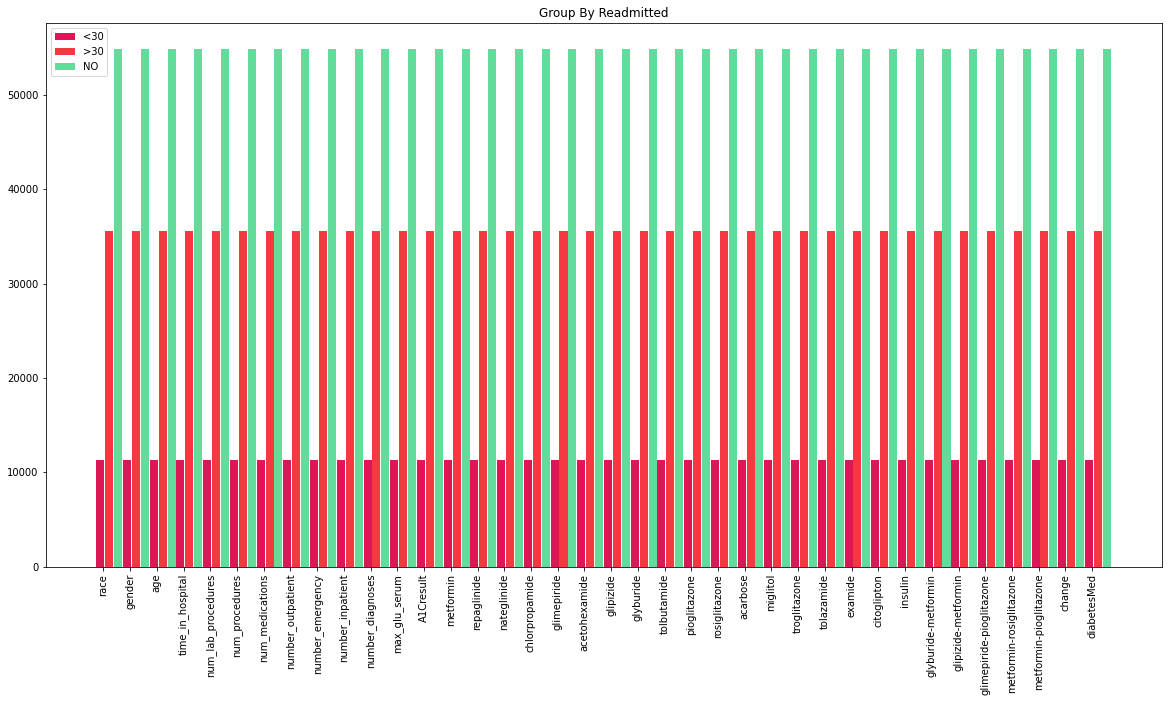

In [0]:
groupByChart('readmitted','Group By Readmitted')

#Normalization

Normlizing the features that has numerical value

In [0]:
scaler = MinMaxScaler(feature_range=[0, 1])
data.iloc[:,3:11] = scaler.fit_transform(data.iloc[:,3:11])

In [0]:
data.head()

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),0.000000,0.305344,0.000000,0.0000,0.000000,0.0,0.000000,0.000000,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),0.153846,0.442748,0.000000,0.2125,0.000000,0.0,0.000000,0.533333,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),0.076923,0.076336,0.833333,0.1500,0.047619,0.0,0.047619,0.333333,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),0.076923,0.328244,0.166667,0.1875,0.000000,0.0,0.000000,0.400000,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),0.000000,0.381679,0.000000,0.0875,0.000000,0.0,0.000000,0.266667,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


##Choose X features y labels

In [0]:
X_diabetesMed = data.iloc[:,0:37]
X_readmitted = data.iloc[:,0:38] #Including diabetesMed as a feature
y_diabetesMed = data.iloc[:,-2] #diabetesMed target
y_readmitted = data.iloc[:,-1] #readmitted target

In [0]:
X_diabetesMed.shape, y_diabetesMed.shape, X_readmitted.shape, y_readmitted.shape

((101766, 37), (101766,), (101766, 38), (101766,))

In [0]:
X_diabetesMed.head()

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change
0,Caucasian,Female,[0-10),0.000000,0.305344,0.000000,0.0000,0.000000,0.0,0.000000,0.000000,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
1,Caucasian,Female,[10-20),0.153846,0.442748,0.000000,0.2125,0.000000,0.0,0.000000,0.533333,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch
2,AfricanAmerican,Female,[20-30),0.076923,0.076336,0.833333,0.1500,0.047619,0.0,0.047619,0.333333,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
3,Caucasian,Male,[30-40),0.076923,0.328244,0.166667,0.1875,0.000000,0.0,0.000000,0.400000,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch
4,Caucasian,Male,[40-50),0.000000,0.381679,0.000000,0.0875,0.000000,0.0,0.000000,0.266667,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch


In [0]:
X_readmitted.head()

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
0,Caucasian,Female,[0-10),0.000000,0.305344,0.000000,0.0000,0.000000,0.0,0.000000,0.000000,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
1,Caucasian,Female,[10-20),0.153846,0.442748,0.000000,0.2125,0.000000,0.0,0.000000,0.533333,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes
2,AfricanAmerican,Female,[20-30),0.076923,0.076336,0.833333,0.1500,0.047619,0.0,0.047619,0.333333,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes
3,Caucasian,Male,[30-40),0.076923,0.328244,0.166667,0.1875,0.000000,0.0,0.000000,0.400000,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes
4,Caucasian,Male,[40-50),0.000000,0.381679,0.000000,0.0875,0.000000,0.0,0.000000,0.266667,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes


##Convert categorical value to numerical

In [0]:
X_diabetesMed = pd.get_dummies(X_diabetesMed)
X_readmitted = pd.get_dummies(X_readmitted)

In [0]:
X_diabetesMed.shape, X_readmitted.shape

((101766, 108), (101766, 110))

In [0]:
X_diabetesMed.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_?,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,gender_Unknown/Invalid,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100),max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_Down,metformin_No,metformin_Steady,metformin_Up,repaglinide_Down,...,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_Down,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_Down,miglitol_No,miglitol_Steady,miglitol_Up,troglitazone_No,troglitazone_Steady,tolazamide_No,tolazamide_Steady,tolazamide_Up,examide_No,citoglipton_No,insulin_Down,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_No,glipizide-metformin_Steady,glimepiride-pioglitazone_No,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,metformin-pioglitazone_Steady,change_Ch,change_No
0,0.000000,0.305344,0.000000,0.0000,0.000000,0.0,0.000000,0.000000,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1
1,0.153846,0.442748,0.000000,0.2125,0.000000,0.0,0.000000,0.533333,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0
2,0.076923,0.076336,0.833333,0.1500,0.047619,0.0,0.047619,0.333333,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1
3,0.076923,0.328244,0.166667,0.1875,0.000000,0.0,0.000000,0.400000,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0
4,0.000000,0.381679,0.000000,0.0875,0.000000,0.0,0.000000,0.266667,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0


In [0]:
X_readmitted.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_?,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,gender_Unknown/Invalid,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100),max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_Down,metformin_No,metformin_Steady,metformin_Up,repaglinide_Down,...,pioglitazone_Up,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_Down,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_Down,miglitol_No,miglitol_Steady,miglitol_Up,troglitazone_No,troglitazone_Steady,tolazamide_No,tolazamide_Steady,tolazamide_Up,examide_No,citoglipton_No,insulin_Down,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_No,glipizide-metformin_Steady,glimepiride-pioglitazone_No,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,metformin-pioglitazone_Steady,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
0,0.000000,0.305344,0.000000,0.0000,0.000000,0.0,0.000000,0.000000,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,1,0
1,0.153846,0.442748,0.000000,0.2125,0.000000,0.0,0.000000,0.533333,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1
2,0.076923,0.076336,0.833333,0.1500,0.047619,0.0,0.047619,0.333333,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1
3,0.076923,0.328244,0.166667,0.1875,0.000000,0.0,0.000000,0.400000,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1
4,0.000000,0.381679,0.000000,0.0875,0.000000,0.0,0.000000,0.266667,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1


convert 'diabetesMed' label to numerical

In [0]:
y_dia = y_diabetesMed.map({'Yes': 1, 'No': 0})
y_dia.head()

0    0
1    1
2    1
3    1
4    1
Name: diabetesMed, dtype: int64

convert 'readmitted' label to numerical

In [0]:
y_rea = y_readmitted.map({'NO': 0, '<30': 1, '>30':2})
y_rea.head()

0    0
1    2
2    0
3    0
4    0
Name: readmitted, dtype: int64

#PCA

In [0]:
from sklearn.decomposition import PCA
pca_red=PCA(n_components=0.95,random_state=57)
X_dia_pca=pca_red.fit_transform(X_diabetesMed,y_dia)
X_rea_pca = pca_red.fit_transform(X_readmitted,y_rea)

In [0]:
X_dia_pca.shape,X_rea_pca.shape

((101766, 28), (101766, 28))

##Select the best 50 features from both diabetes and readmitted

In [0]:
skb = SelectKBest(chi2, k=50)
X_dia_kbest = skb.fit_transform(X_diabetesMed,y_dia)
X_rea_kbest = skb.fit_transform(X_readmitted,y_rea)

In [0]:
# For vizaulizing the important features
X_dia_fit = skb.fit(X_diabetesMed, y_dia)
X_rea_fit = skb.fit(X_readmitted, y_rea)

###Best 50 features for 'diabetesMed'

In [0]:
X_dia_scores=pd.DataFrame(X_dia_fit.scores_)
X_dia_columns = pd.DataFrame(X_diabetesMed.columns)
dia_scores = pd.concat([X_dia_columns,X_dia_scores],axis=1)
dia_scores.columns=['Features','Score']

See the 50 highest score of importance features

In [0]:
print(dia_scores.nlargest(50,'Score'))

                 Features       Score
6        number_inpatient  669.216104
108                   NaN  297.625459
90           insulin_Down  238.872885
8                  race_?  183.884314
93             insulin_Up  138.744906
91             insulin_No  125.573774
106             change_Ch  116.124225
107             change_No   99.700776
109                   NaN   88.885426
2          num_procedures   74.810104
4       number_outpatient   73.041399
37       metformin_Steady   69.026049
0        time_in_hospital   68.531651
5        number_emergency   65.284473
17             age_[0-10)   52.263554
22            age_[50-60)   51.068381
41     repaglinide_Steady   50.945966
7        number_diagnoses   50.229612
26           age_[90-100)   47.805649
28     max_glu_serum_>300   46.563414
24            age_[70-80)   43.780201
34         A1Cresult_Norm   39.746656
25            age_[80-90)   36.127732
77        acarbose_Steady   32.893416
10             race_Asian   32.209511
73   rosigli

###Best 50 features for 'readmitted'

In [0]:
X_rea_scores = pd.DataFrame(X_rea_fit.scores_)
X_rea_columns = pd.DataFrame(X_readmitted.columns)
rea_scores=pd.concat([X_rea_columns,X_rea_scores],axis=1)
rea_scores.columns = ['Features','Score']

In [0]:
print(rea_scores.nlargest(50,'Score'))

                 Features       Score
6        number_inpatient  669.216104
108        diabetesMed_No  297.625459
90           insulin_Down  238.872885
8                  race_?  183.884314
93             insulin_Up  138.744906
91             insulin_No  125.573774
106             change_Ch  116.124225
107             change_No   99.700776
109       diabetesMed_Yes   88.885426
2          num_procedures   74.810104
4       number_outpatient   73.041399
37       metformin_Steady   69.026049
0        time_in_hospital   68.531651
5        number_emergency   65.284473
17             age_[0-10)   52.263554
22            age_[50-60)   51.068381
41     repaglinide_Steady   50.945966
7        number_diagnoses   50.229612
26           age_[90-100)   47.805649
28     max_glu_serum_>300   46.563414
24            age_[70-80)   43.780201
34         A1Cresult_Norm   39.746656
25            age_[80-90)   36.127732
77        acarbose_Steady   32.893416
10             race_Asian   32.209511
73   rosigli

#Splitting The Data

Here, Split the data for training and testing set in ration 70%-30%

In [0]:
#For diabetesMed using 50 best features
X_train_dia_kbest, X_test_dia_kbest, y_train_dia_kbest, y_test_dia_kbest = train_test_split(X_dia_kbest,y_dia, test_size=0.3, shuffle = True, random_state=42)
#For diabetesMed using PCA
X_train_dia_pca, X_test_dia_pca, y_train_dia_pca, y_test_dia_pca = train_test_split(X_dia_pca,y_dia, test_size=0.3, shuffle = True, random_state=42)

In [0]:
#For readmitted using 50 best features
X_train_rea_kbest, X_test_rea_kbest, y_train_rea_kbest, y_test_rea_kbest = train_test_split(X_rea_kbest,y_rea, test_size=0.3, shuffle = True, random_state=42)
#For readmitted using PCA
X_train_rea_pca, X_test_rea_pca, y_train_rea_pca, y_test_rea_pca = train_test_split(X_rea_pca,y_rea, test_size=0.3, shuffle = True, random_state=42)

#Building The Models

##RandomForest Model

In [0]:
rnd_clf = RandomForestClassifier(n_estimators=10)

This to save the times taking and the accuracies of each run

In [0]:
times_list = dict()
accs_list = dict()

###for 'diabetMed'

Perform Cross Validation with subset size 10000


In [0]:
#For K best features
cross_val_score(rnd_clf, X_train_dia_kbest[:10000], y_train_dia_kbest[:10000], cv=3, scoring='accuracy').mean()

0.9976000899430075

Fit the model with training set

In [0]:
#For the k best Features
t0 = time.time()
rnd_clf.fit(X_train_dia_kbest, y_train_dia_kbest)
t1 = time.time()

In [0]:
rnd_clf_dia_kbest=t1-t0
times_list['rnd_clf_dia_kbest']=rnd_clf_dia_kbest
print("Training took {:.2f}s".format(rnd_clf_dia_kbest))

Training took 0.35s


Test the model with testing set

In [0]:
#For PCA
cross_val_score(rnd_clf, X_train_dia_pca[:10000], y_train_dia_pca[:10000], cv=3, scoring='accuracy').mean()

0.9942001698670166

In [0]:
rnd_clf_dia_score_kbest=rnd_clf.score(X_test_dia_kbest, y_test_dia_kbest)
accs_list['rnd_clf_dia_score_kbest']=rnd_clf_dia_score_kbest
rnd_clf_dia_score_kbest

0.9995086799868982

In [0]:
#For PCA
t0 = time.time()
rnd_clf.fit(X_train_dia_pca, y_train_dia_pca)
t1 = time.time()

In [0]:
rnd_clf_dia_pca=t1-t0
times_list['rnd_clf_dia_pca']=rnd_clf_dia_pca 
print("Training took {:.2f}s".format(rnd_clf_dia_pca))

Training took 3.10s


Test the model with testing set

In [0]:
rnd_clf_dia_score_pca=rnd_clf.score(X_test_dia_pca, y_test_dia_pca)
accs_list['rnd_clf_dia_score_pca']=rnd_clf_dia_score_pca
rnd_clf_dia_score_pca

0.9976744186046511

Compare RND using KBest and PCA

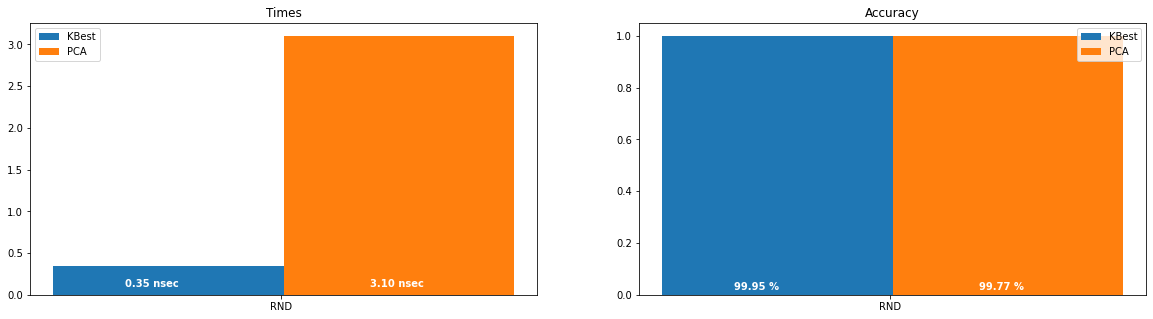

In [0]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.bar(1,times_list['rnd_clf_dia_kbest'],label='KBest')
plt.bar(1.80,times_list['rnd_clf_dia_pca'],label='PCA')
plt.xticks([1.39],['RND'])
plt.text(0.85,0.1,'{:.2f} nsec'.format(times_list['rnd_clf_dia_kbest']),color='white',weight='bold')
plt.text(1.7,0.1,'{:.2f} nsec'.format(times_list['rnd_clf_dia_pca']),color='white',weight='bold')
plt.legend()
plt.title('Times')

plt.subplot(1,2,2)
plt.bar(1,accs_list['rnd_clf_dia_score_kbest'],label='KBest')
plt.bar(1.80,accs_list['rnd_clf_dia_score_pca'],label='PCA')
plt.xticks([1.39],['RND'])
plt.text(0.85,0.02,'{:.2f} %'.format(accs_list['rnd_clf_dia_score_kbest']*100),color='white',weight='bold')
plt.text(1.7,0.02,'{:.2f} %'.format(accs_list['rnd_clf_dia_score_pca']*100),color='white',weight='bold')
plt.legend()
plt.title('Accuracy')
plt.show()
plt.show()

###for 'readmitted'

Perform Cross Validation with subset size 10000

In [0]:
#For K best features
cross_val_score(rnd_clf, X_train_rea_kbest[:10000], y_train_rea_kbest[:10000], cv=3, scoring='accuracy').mean()

0.5223990305449261

Fit the model with training set for K best

In [0]:
#For K best features
t0 = time.time()
rnd_clf.fit(X_train_rea_kbest, y_train_rea_kbest)
t1 = time.time()

In [0]:
rnd_clf_rea_kbest = t1-t0
times_list['rnd_clf_rea_kbest']=rnd_clf_rea_kbest
print("Training took {:.2f}s".format(rnd_clf_rea_kbest))

Training took 1.27s


Test the model with testing set for K best

In [0]:
rnd_clf_rea_score_kbest=rnd_clf.score(X_test_rea_kbest, y_test_rea_kbest)
accs_list['rnd_clf_rea_score_kbest'] = rnd_clf_rea_score_kbest
rnd_clf_rea_score_kbest

0.5252538486734359

Predict y 'readmitted' for K best and see Precision, Recall and F1 report.

In [0]:
#For K best
y_pred_rnd_rea_kbest = rnd_clf.predict(X_test_rea_kbest)
print(classification_report(y_test_dia_kbest,y_pred_rnd_rea_kbest))

              precision    recall  f1-score   support

           0       0.25      0.77      0.38      6874
           1       0.82      0.03      0.07     23656
           2       0.00      0.00      0.00         0

    accuracy                           0.20     30530
   macro avg       0.36      0.27      0.15     30530
weighted avg       0.69      0.20      0.14     30530



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fit the model with training set for PCA

In [0]:
#For PCA
cross_val_score(rnd_clf, X_train_rea_pca[:10000], y_train_rea_pca[:10000], cv=3, scoring='accuracy').mean()

0.4961993499889881

In [0]:
t0 = time.time()
rnd_clf.fit(X_train_rea_pca, y_train_rea_pca)
t1 = time.time()

In [0]:
rnd_clf_rea_pca = t1-t0
times_list['rnd_clf_rea_pca']=rnd_clf_rea_pca
print("Training took {:.2f}s".format(rnd_clf_rea_pca))

Training took 6.22s


Test the model with testing set for PCA

In [0]:
rnd_clf_rea_score_pca=rnd_clf.score(X_test_rea_pca, y_test_rea_pca)
accs_list['rnd_clf_rea_score_pca'] = rnd_clf_rea_score_pca
rnd_clf_rea_score_pca

0.4907304290861448

Predict y 'readmitted' for PCA and see Precision, Recall and F1 report

In [0]:
#For PCA
y_pred_rnd_rea_pca = rnd_clf.predict(X_test_rea_pca)
print(classification_report(y_test_rea_pca,y_pred_rnd_rea_pca))

              precision    recall  f1-score   support

           0       0.56      0.70      0.62     16461
           1       0.15      0.06      0.09      3425
           2       0.38      0.30      0.34     10644

    accuracy                           0.49     30530
   macro avg       0.36      0.35      0.35     30530
weighted avg       0.45      0.49      0.46     30530



Compare RND using KBest and PCA

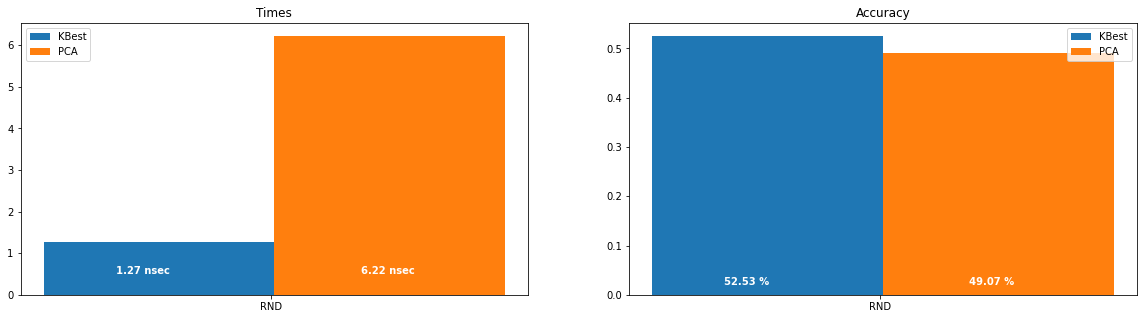

In [0]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.bar(1,times_list['rnd_clf_rea_kbest'],label='KBest')
plt.bar(1.80,times_list['rnd_clf_rea_pca'],label='PCA')
plt.xticks([1.39],['RND'])
plt.text(0.85,0.5,'{:.2f} nsec'.format(times_list['rnd_clf_rea_kbest']),color='white',weight='bold')
plt.text(1.7,0.5,'{:.2f} nsec'.format(times_list['rnd_clf_rea_pca']),color='white',weight='bold')
plt.legend()
plt.title('Times')

plt.subplot(1,2,2)
plt.bar(1,accs_list['rnd_clf_rea_score_kbest'],label='KBest')
plt.bar(1.80,accs_list['rnd_clf_rea_score_pca'],label='PCA')
plt.xticks([1.39],['RND'])
plt.text(0.85,0.02,'{:.2f} %'.format(accs_list['rnd_clf_rea_score_kbest']*100),color='white',weight='bold')
plt.text(1.7,0.02,'{:.2f} %'.format(accs_list['rnd_clf_rea_score_pca']*100),color='white',weight='bold')
plt.legend()
plt.title('Accuracy')
plt.show()
plt.show()

##SVM (nom-linear kernel) Model

In [0]:
svm_clf = svm_clf = SVC(gamma='auto', degree=2, kernel='poly') #Non-linear degree=2

###for 'diabetMed'

Perform Cross Validation with subset size 10000 for Kbest

In [0]:
cross_val_score(svm_clf, X_train_dia_kbest[:10000], y_train_dia_kbest[:10000], cv=3, scoring='accuracy').mean()

0.9901001797840253

Fit the model with training set for Kbest

In [0]:
t0 = time.time()
svm_clf.fit(X_train_dia_kbest, y_train_dia_kbest)
t1 = time.time()

In [0]:
svm_clf_dia_kbest = t1-t0
times_list['svm_clf_dia_kbest']=svm_clf_dia_kbest
print("Training took {:.2f}s".format(svm_clf_dia_kbest))

Training took 168.91s


Test the model with testing set for KBest

In [0]:
svm_clf_dia_score_kbest=svm_clf.score(X_test_dia_kbest, y_test_dia_kbest)
accs_list['svm_clf_dia_score_kbest']=svm_clf_dia_score_kbest
svm_clf_dia_score_kbest

0.9972158532590895

Perform Cross Validation with subset size 10000 for PCA

In [0]:
cross_val_score(svm_clf, X_train_dia_pca[:10000], y_train_dia_pca[:10000], cv=3, scoring='accuracy').mean()

0.7983003159344128

Fit the model with training set for PCA

In [0]:
t0 = time.time()
svm_clf.fit(X_train_dia_pca, y_train_dia_pca)
t1 = time.time()

In [0]:
svm_clf_dia_pca = t1-t0
times_list['svm_clf_dia_pca']=svm_clf_dia_pca
print("Training took {:.2f}s".format(svm_clf_dia_pca))

Training took 62.01s


Test the model with testing set for PCA

In [0]:
svm_clf_dia_score_pca=svm_clf.score(X_test_dia_pca, y_test_dia_pca)
accs_list['svm_clf_dia_score_pca']=svm_clf_dia_score_pca
svm_clf_dia_score_pca

0.9954798558794629

Compare RND using KBest and PCA

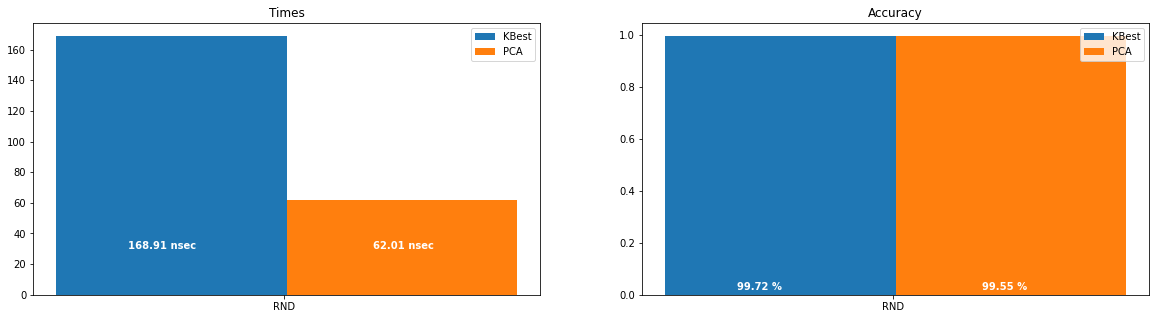

In [0]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.bar(1,times_list['svm_clf_dia_kbest'],label='KBest')
plt.bar(1.80,times_list['svm_clf_dia_pca'],label='PCA')
plt.xticks([1.39],['RND'])
plt.text(0.85,30,'{:.2f} nsec'.format(times_list['svm_clf_dia_kbest']),color='white',weight='bold')
plt.text(1.7,30,'{:.2f} nsec'.format(times_list['svm_clf_dia_pca']),color='white',weight='bold')
plt.legend()
plt.title('Times')

plt.subplot(1,2,2)
plt.bar(1,accs_list['svm_clf_dia_score_kbest'],label='KBest')
plt.bar(1.80,accs_list['svm_clf_dia_score_pca'],label='PCA')
plt.xticks([1.39],['RND'])
plt.text(0.85,0.02,'{:.2f} %'.format(accs_list['svm_clf_dia_score_kbest']*100),color='white',weight='bold')
plt.text(1.7,0.02,'{:.2f} %'.format(accs_list['svm_clf_dia_score_pca']*100),color='white',weight='bold')
plt.legend()
plt.title('Accuracy')
plt.show()
plt.show()

###for 'readmitted'

Perform Cross Validation with subset size 10000 for KBest

In [0]:
cross_val_score(svm_clf, X_train_rea_kbest[:10000], y_train_rea_kbest[:10000], cv=3, scoring='accuracy').mean()

0.5379999907609238

Fit the model with training set for KBest

In [0]:
t0 = time.time()
svm_clf.fit(X_train_rea_kbest, y_train_rea_kbest)
t1 = time.time()

In [0]:
svm_clf_rea_kbest = t1-t0
times_list['svm_clf_rea_kbest']=svm_clf_rea_kbest
print("Training took {:.2f}s".format(svm_clf_rea_kbest))

Training took 842.63s


Test the model with testing set for KBest

In [0]:
svm_clf_rea_score_kbest=svm_clf.score(X_test_rea_kbest, y_test_rea_kbest)
accs_list['svm_clf_rea_score_kbest']=svm_clf_rea_score_kbest
svm_clf_rea_score_kbest

0.5391745823779889

Predict y 'readmitted' for KBest

In [0]:
y_pred_svm_rea_kbest = svm_clf.predict(X_test_rea_kbest)

See Precision, Recall and F1 report for KBest

In [0]:
print(classification_report(y_test_rea_kbest, y_pred_svm_rea_kbest))

              precision    recall  f1-score   support

           0       0.54      1.00      0.70     16461
           1       0.00      0.00      0.00      3425
           2       0.00      0.00      0.00     10644

    accuracy                           0.54     30530
   macro avg       0.18      0.33      0.23     30530
weighted avg       0.29      0.54      0.38     30530



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Perform Cross Validation with subset size 10000 for PCA

In [0]:
cross_val_score(svm_clf, X_train_rea_pca[:10000], y_train_rea_pca[:10000], cv=3, scoring='accuracy').mean()


0.5379999907609238

Fit the model with training set for PCA

In [0]:
t0 = time.time()
svm_clf.fit(X_train_rea_pca, y_train_rea_pca)
t1 = time.time()

In [0]:
svm_clf_rea_pca = t1-t0
times_list['svm_clf_rea_pca']=svm_clf_rea_pca
print("Training took {:.2f}s".format(svm_clf_rea_pca))

Training took 427.88s


Test the model with testing set for PCA

In [0]:
svm_clf_rea_score_pca=svm_clf.score(X_test_rea_pca, y_test_rea_pca)
accs_list['svm_clf_rea_score_pca']=svm_clf_rea_score_pca
svm_clf_rea_score_pca

0.5391745823779889

Predict y 'readmitted' for PCA

In [0]:
y_pred_svm_rea_pca = svm_clf.predict(X_test_rea_pca)

See Precision, Recall and F1 report for PCA

In [0]:
print(classification_report(y_test_rea_pca, y_pred_svm_rea_pca))

              precision    recall  f1-score   support

           0       0.54      1.00      0.70     16461
           1       0.00      0.00      0.00      3425
           2       0.00      0.00      0.00     10644

    accuracy                           0.54     30530
   macro avg       0.18      0.33      0.23     30530
weighted avg       0.29      0.54      0.38     30530



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Compare SVM using KBest and PCA

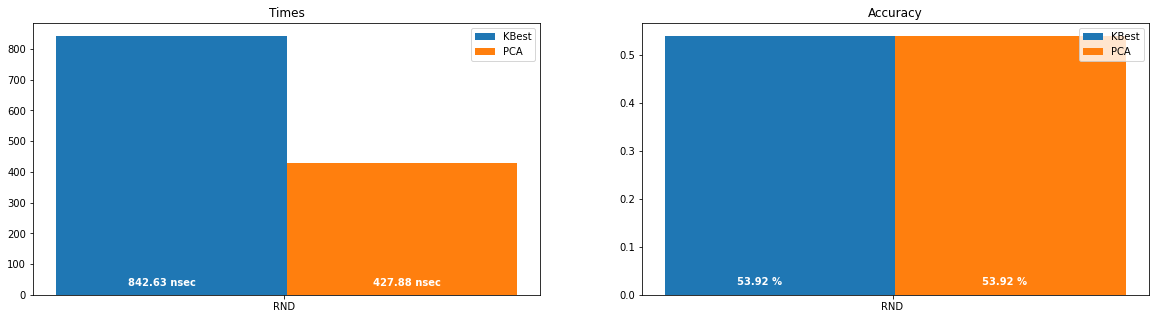

In [0]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.bar(1,times_list['svm_clf_rea_kbest'],label='KBest')
plt.bar(1.80,times_list['svm_clf_rea_pca'],label='PCA')
plt.xticks([1.39],['RND'])
plt.text(0.85,30,'{:.2f} nsec'.format(times_list['svm_clf_rea_kbest']),color='white',weight='bold')
plt.text(1.7,30,'{:.2f} nsec'.format(times_list['svm_clf_rea_pca']),color='white',weight='bold')
plt.legend()
plt.title('Times')

plt.subplot(1,2,2)
plt.bar(1,accs_list['svm_clf_rea_score_kbest'],label='KBest')
plt.bar(1.80,accs_list['svm_clf_rea_score_pca'],label='PCA')
plt.xticks([1.39],['RND'])
plt.text(0.85,0.02,'{:.2f} %'.format(accs_list['svm_clf_rea_score_kbest']*100),color='white',weight='bold')
plt.text(1.7,0.02,'{:.2f} %'.format(accs_list['svm_clf_rea_score_kbest']*100),color='white',weight='bold')
plt.legend()
plt.title('Accuracy')
plt.show()
plt.show()

Plot the learning curve for 'readmitted'

In [0]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
  if axes is None:
        _, axes = plt.subplots(2, 1, figsize=(20, 5))

  axes.set_title(title)
  if ylim is not None:
        axes.set_ylim(*ylim)
  axes.set_xlabel("Training examples")
  axes.set_ylabel("Score")

  train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)

  # Plot learning curve
  axes.grid()
  axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
  axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
  axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
  axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
  axes.legend(loc="best")
  return plt

Plot the learning curve for both RandomForest and SVC. For SVC, displaying the curve takes long time so a subset of size 10,000 of the data will be used to fast generate the chart.

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


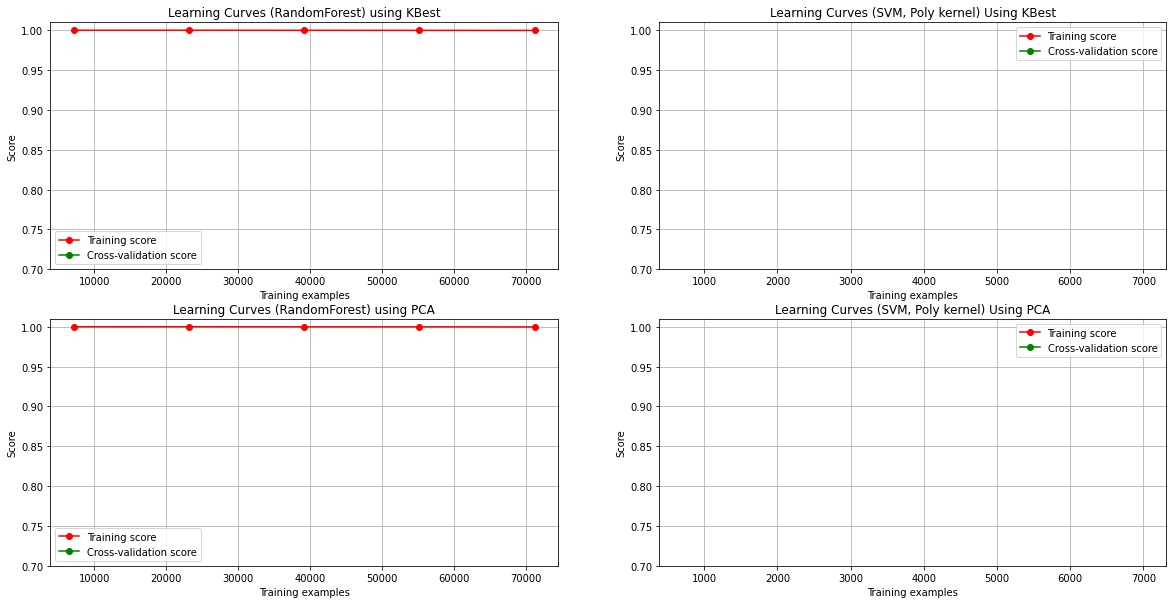

In [0]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

X, y = X_rea_kbest, y_rea

title = "Learning Curves (RandomForest) using KBest"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=42)

estimator = RandomForestClassifier()
plt_curve=plot_learning_curve(estimator, title, X, y, axes=axes[0,0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)


title = "Learning Curves (SVM, Poly kernel) Using KBest"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=42)
estimator = SVC(gamma='auto')
plot_learning_curve(estimator, title, X[:10000], y[:10000], axes=axes[0,1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)


X, y = X_rea_pca, y_rea

title = "Learning Curves (RandomForest) using PCA"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=42)

estimator = RandomForestClassifier()
plot_learning_curve(estimator, title, X, y, axes=axes[1,0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)


title = "Learning Curves (SVM, Poly kernel) Using PCA"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=42)
estimator = SVC(gamma='auto')
plot_learning_curve(estimator, title, X[:10000], y[:10000], axes=axes[1,1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)


plt.show()

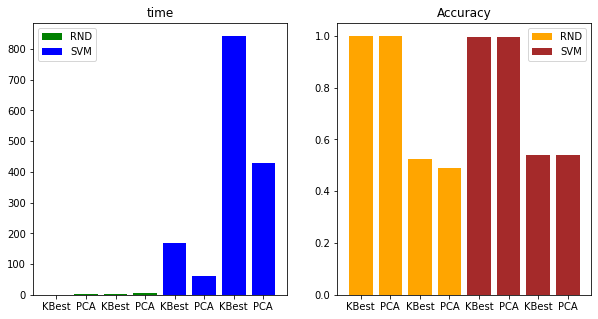

In [0]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
green=plt.bar(1,times_list['rnd_clf_dia_kbest'],color='green')
plt.bar(2,times_list['rnd_clf_dia_pca'],color='green')
plt.bar(3,times_list['rnd_clf_rea_kbest'],color='green')
plt.bar(4,times_list['rnd_clf_rea_pca'],color='green')

blue=plt.bar(5,times_list['svm_clf_dia_kbest'],color='blue')
plt.bar(6,times_list['svm_clf_dia_pca'],color='blue')
plt.bar(7,times_list['svm_clf_rea_kbest'],color='blue')
plt.bar(8,times_list['svm_clf_rea_pca'],color='blue')
plt.title('time')

plt.xticks([1,2,3,4,5,6,7,8],['KBest','PCA','KBest','PCA','KBest','PCA','KBest','PCA'])
plt.legend([green,blue],['RND','SVM'])


plt.subplot(1,2,2)
orange=plt.bar(1,accs_list['rnd_clf_dia_score_kbest'],color='orange')
plt.bar(2,accs_list['rnd_clf_dia_score_pca'],color='orange')
plt.bar(3,accs_list['rnd_clf_rea_score_kbest'],color='orange')
plt.bar(4,accs_list['rnd_clf_rea_score_pca'],color='orange')

brown=plt.bar(5,accs_list['svm_clf_dia_score_kbest'],color='brown')
plt.bar(6,accs_list['svm_clf_dia_score_pca'],color='brown')
plt.bar(7,accs_list['svm_clf_rea_score_kbest'],color='brown')
plt.bar(8,accs_list['svm_clf_rea_score_pca'],color='brown')
plt.title('Accuracy')

plt.xticks([1,2,3,4,5,6,7,8],['KBest','PCA','KBest','PCA','KBest','PCA','KBest','PCA'])
plt.legend([orange,brown],['RND','SVM'])

plt.show()

##Testing on different size of features

###KBest and PCA


In [0]:

Xtrain_dia, Xtest_dia, ytrain_dia, ytest_dia = train_test_split(X_diabetesMed,y_diabetesMed, test_size=0.3, shuffle = True, random_state=42)

Xtrain_rea, Xtest_rea, ytrain_rea, ytest_rea = train_test_split(X_readmitted,y_readmitted, test_size=0.3, shuffle = True, random_state=42)

In [0]:
sizes=[20,30,50,70,90,100,Xtrain_dia.shape[1]]
sizes

[20, 30, 50, 70, 90, 100, 108]

In [0]:
def drawCompareChartInSizeKBest(model,sizesList,title,xtrain,ytrain,xtest,ytest):
  rnd_score=[]
  rnd_size=[]
  rnd_time=[]

  for i in sizesList:
    rnd_pipe= Pipeline([['KBest',SelectKBest(k=i)],
                      ['model',model]])
    
    rnd_size.append(i)

    time1 = time.time()
    rnd_pipe.fit(xtrain,ytrain)
    time2 = time.time()
    rnd_time.append(time2-time1)

    score=rnd_pipe.score(xtest,ytest)
    rnd_score.append(score)

  #plt.figure(figsize=(figureHeight,figureWidth))
  xcount=1
  for (scoreV,timeV,sizeV) in zip(rnd_score,rnd_time,rnd_size):
    green=plt.bar(xcount,sizeV,label='Size',color='green')
    xcount +=1
    blue=plt.bar(xcount,scoreV*100,label='Accuracy',color='blue')
    xcount +=1
    orange=plt.bar(xcount,timeV,label='Time',color='orange')
    xcount +=1
    
  plt.legend([blue,orange,green],['Accuracy','Time','Size'])
  plt.title(title)
  plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21],
              ['Size','Accuracy','Time','Size','Accuracy','Time','Size','Accuracy','Time',
              'Size','Accuracy','Time','Size','Accuracy','Time','Size','Accuracy','Time',
              'Size','Accuracy','Time'],rotation=90)


In [0]:
#Disable showing the warnings message
import warnings
warnings.filterwarnings('ignore')

In [0]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
drawCompareChartInSizeKBest(RandomForestClassifier(n_estimators=10),sizes,'RND for DiabetesMed Using KBest',Xtrain_dia,ytrain_dia,
                            Xtest_dia,ytest_dia)


plt.subplot(1,2,2)
drawCompareChartInSizeKBest(RandomForestClassifier(n_estimators=10),sizes,'RND for Readmitted Using KBest',Xtrain_rea,ytrain_rea,
                            Xtest_rea,ytest_rea)

plt.subplots_adjust(hspace=1)

plt.subplot(2,2,3)
drawCompareChartInSizeKBest(SVC(gamma='auto', degree=2, kernel='poly'),sizes,'SVM for DiabetesMed Using KBest',Xtrain_dia,ytrain_dia,
                            Xtest_dia,ytest_dia)

#SVC(gamma='auto', degree=2, kernel='poly')
plt.subplot(2,2,4)
drawCompareChartInSizeKBest(SVC(gamma='auto', degree=2, kernel='poly'),sizes,'SVM for Readmitted Using KBest',Xtrain_rea,ytrain_rea,
                            Xtest_rea,ytest_rea)

plt.show()

#Use GridSearchCV to find the best model (Hyperparameter Tuning) 

Using subset size 10000 to avoid time consuming

RandomForest Model

In [0]:
rnd_pipe = make_pipeline(RandomForestClassifier())
# Create dictionary with candidate learning algorithms and their hyperparameters
rnd_param = [
                {"randomforestclassifier": [RandomForestClassifier()],
                 "randomforestclassifier__n_estimators": [10,50,100],
                 "randomforestclassifier__max_depth":[10,30,50,None],
                 "randomforestclassifier__min_samples_leaf":[5,10,20,50],
                 "randomforestclassifier__max_leaf_nodes": [5,10,20,50]}
              ]

create a gridsearch of the pipeline, then fit the dataset to find best model

In [0]:
rnd_gs = GridSearchCV(rnd_pipe, rnd_param, verbose=0,n_jobs=-1)

Fit the model with training set

In [0]:
rnd_best_model = rnd_gs.fit(X_train_rea[:10000], y_train_rea[:10000])

See the best learning model parameters

In [0]:
print(rnd_best_model.best_estimator_)

Test the model with testing set

In [0]:
print(("The accuracy is:"), rnd_best_model.score(X_test_rea[:10000], y_test_rea[:10000]))

SVM Model

In [0]:
# Create dictionary with candidate learning algorithms and their hyperparameters
svm_param = [
             {'kernel': ['rbf'], 'gamma': [0.1,0.2],'C': [1,10]},
             {'kernel': ['linear'], 'gamma': [0.1,0.2],'C': [1,10]},
             {'kernel': ['poly'], 'gamma': [0.1,0.2],'C': [1,10]}
            ]

create a gridsearch of the pipeline, then fit the dataset to find best model

In [0]:
svm_gs = GridSearchCV(SVC(), svm_param)

Fit the model with training set

In [0]:
svm_best_model = svm_gs.fit(X_train_rea[:10000], y_train_rea[:10000])

See the best learning model parameters

In [0]:
print(svm_best_model.best_estimator_)

Test the model with testing set

In [0]:
print(("The accuracy is:"), svm_best_model.score(X_test_rea[:10000], y_test_rea[:10000]))

#Bonus

Let's generate additional features from existing features, hopefully it will give a better accuracy.  
Let's use the top highest important features.

In [0]:
X_readmitted['f1'] = X_readmitted['insulin_No'] * X_readmitted['diabetesMed_No']
X_readmitted['f2'] = X_readmitted['insulin_Up'] * X_readmitted['diabetesMed_Yes']
X_readmitted['f3'] = X_readmitted['number_inpatient'] * X_readmitted['time_in_hospital']
X_readmitted['f4'] = X_readmitted['number_diagnoses'] * X_readmitted['diabetesMed_Yes']

In [0]:
X_readmitted.head()

In [0]:
X_readmitted.shape

Select Features

In [0]:
skb = SelectKBest(chi2, k=100)
X_new = skb.fit_transform(X_readmitted,y_rea)

In [0]:
X_new.shape

Split the training and testing set

In [0]:
#For readmitted
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new,y_rea, test_size=0.3, shuffle = True, random_state=42)

Using RandomForest with the best model parameters we found above

In [0]:
rnd_clf_new = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=50, max_features='auto',
                                        max_leaf_nodes=50, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=5, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False)

Fit the model with training set

In [0]:
rnd_clf_new.fit(X_train_new, y_train_new)

Test the model with testing set

In [0]:
rnd_clf_new.score(X_test_new, y_test_new)

It is clearly proved that, adding extra features from existing features also will not improve the learning performace.

#Summary and Conclusion


In this diabete patients dataset, many methods were used at the data cleansing section, especially at the feature engineering phase.

For 'diabetesMed' classification, accuracy produced by both models is same 99%, but SVM model learning time took very much longer than RandomForest. 

For 'readmitted' classification, accuracy produced by RandomForest model is around 54% and SVM model is 57%, and once again SVM computation time is much longer. Let's assume time is not matter, which classifier predict better if both produced same accuracies? By looking at the average F1 score, RandomForest F1=0.37 > SVM F1=0.29, this mean RandomForest model predict better in term of precision and recall.  
See the barcharts below for the experiment summary base on features selection. This two barcharts indicated that increasing number of features did not effect to the model performance at all.

![alt text](https://github.com/seansothey/CSC685/blob/master/diabetesMed-report-project5.PNG?raw=true)

![alt text](https://github.com/seansothey/CSC685/blob/master/readmitted-report-project5.PNG?raw=true)

Now, how can we improve the performance for 'readmitted' patients classification? According to the Learning curve behaviour, getting more sample set size will not improve the accuracy. In otherwords, trying to get more data will not be helpful.

GridSearchCV was used for tuning both classifiers for readmitted patient. By looking at GridSearchCV learning model with many different parameters setup, the performance was still not improved. 

Overall, RandomForest is considered for best learning model for this dataset. Trying to get some more new information (features) from patients may be helpful for improve the learning performance for classification of 'readmitted' patients.  


*Note: An important lesson learned from this data set was when applying PCA and scaling the data was not helpful and even made the model performance worse. This is because most of the data value are categorical (0,1,2 after convertion), therefore, the classifiers would learn better with this descrete value.*

#Refrences



*   https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008

*   https://sju.instructure.com/courses/20477/files/2050722?module_item_id=691863

*   https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

*   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html



